## COVID Chest X-Ray Classifications

**Team:**
* Yuan Zhou 
* Amanuel Gebremariam 

**Course:** Deep Learning (Fall 2021)

### Problem Statement
* This project aims to reliably identify COVID-19 through chest X-Ray images using transfer learning and even transformers to boost efficiency in COVID-19 management, especially before the potential outbreak of OMICRON variant
    
    
* **Keywords:** COVID-19 Management, Transfer Learning , VGG19 , Model FineTuning
	

### Data Collection
* Source(url): https://www.kaggle.com/amanullahasraf/covid19-pneumonia-normal-chest-xray-pa-dataset
* Short Description : The data set of COVID-19 Chest X-Ray images (2021)

* Keywords: Chest X-ray, COVID-19, Pneumonia

### Required packages

* Add instructions to install the required packages

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

# Adapted from: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/ 
# Plotting function to visualize results
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label = 'accuracy (training data)')
    plt.plot(history.history['val_accuracy'], label = 'accuracy (validation data)')
    plt.title('Trajectory for Accuracy')
    plt.ylabel('Accuracy Value')
    plt.xlabel('No. Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'], label = 'loss function (training data)')
    plt.plot(history.history['val_loss'], label = 'loss function (validation data)')
    plt.title('Trajectory for Loss Function')
    plt.ylabel('Loss Function Value')
    plt.xlabel('No. Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [37]:
from matplotlib.image import imread
def explore_dimensions(path, labels):
    # credit to Suradech Kongkiatpaiboon
    import seaborn as sns
    #Explore the avearage dimension of the images
    dim1 = []
    dim2 = []
    for image_filename in os.listdir(path+'//'+labels):    
      
        img = imread(path+'//'+labels+'//'+image_filename)
        if len(img.shape)==2: #Reshape some images with single color channel
            img = img.reshape(img.shape[0],img.shape[1],1)
        d1,d2,colors = img.shape
        dim1.append(d1)
        dim2.append(d2)
    p = sns.jointplot(dim1,dim2)
    p.fig.suptitle("Dimensions of "+labels+ " images")

In [50]:
# Adapted from: https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

#fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    all_labels =['covid', 'normal', 'pneumonia']
    for (idx, c_label) in enumerate(all_labels):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
        c_ax.legend()
    return roc_auc_score(y_test, y_pred, average=average)

## GPU settings

In [8]:
#  Check if the GPU is installed
physical_devices = tf.config.list_physical_devices('GPU')
print('Num GPUs:', len(physical_devices))

Num GPUs: 0


In [9]:
batch_size = 32
img_height = 128
img_width = 128

data_dir = 'C:/Users/zhouy/Desktop/DAAN570/project_data/'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6902 files belonging to 3 classes.
Using 5522 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6902 files belonging to 3 classes.
Using 1380 files for validation.


In [11]:
print(tf.__version__)

2.7.0


In [12]:
class_names = train_ds.class_names
print(class_names)

['covid', 'normal', 'pneumonia']


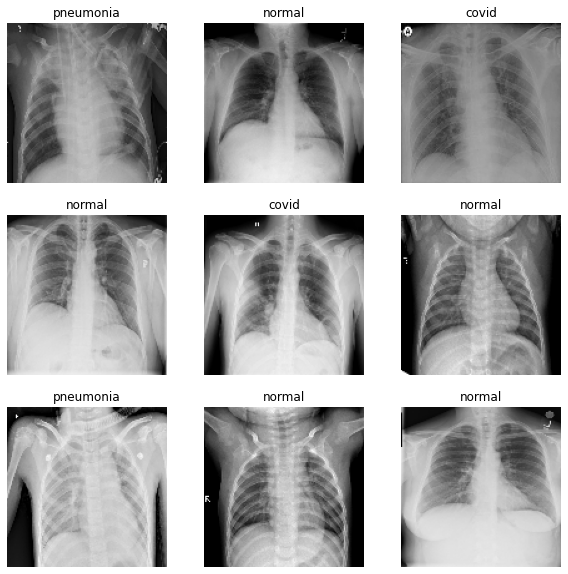

In [74]:
import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    #print(images[i])
    #print(labels[i])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Data Preprocessing

* The dataset contains a total of 6939 image files divided equally into 3 classes (covid, pneumonia, normal)
* Resized into 128 x 128 pixels in order to reduce computational complexity
* Split the data into 80% train and 20% test sets 

In [75]:
# number of images per class
print("Number of COVID chest X-ray images : " + str(len(os.listdir(data_dir+'//covid'))))
print("Number of pneumonia chest X-ray images : " + str(len(os.listdir(data_dir+'//pneumonia'))))
print("Number of normal chest X-ray images : " + str(len(os.listdir(data_dir+'//normal'))))

Number of COVID chest X-ray images : 2313
Number of pneumonia chest X-ray images : 2313
Number of normal chest X-ray images : 2313


C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


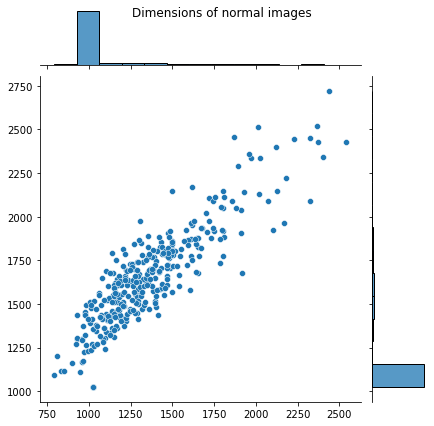

In [76]:
# optimal dimension -- pixel
#explore_dimensions(data_dir, 'covid')
#explore_dimensions(data_dir, 'pneumonia')
explore_dimensions(data_dir, 'normal')

The exploration plots suggest that an image dimension of 1000 x 1000 pixels can be used to resize all images.

In [13]:
size = (128, 128)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [14]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)

In [79]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [80]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create a model with transfer learning

### Methodology

1. Explan your Deep Learning process / methodology
 * Transfer learning is: model developed for a task is reused as the starting point for a model on a second task

2. Introduce the Deep Neural Networks you used in your project
 * Model 1
    * Plain VGG 19 model adapted adding an output layer 
 
 * Model 2
    * VGG19 Finetuning adding additional conv2D layers
 
 * Model 3
     * VG19 Extended Plus Data Augmentation 
 
3. Add keywords  
**Keywords:** multi-label classification

### VGG19

In [81]:
# Create a model with transfer learning
from tensorflow.keras.applications.vgg19 import VGG19
num_classes = 3
base_model = VGG19(weights='imagenet',
                   input_shape= (128,128,3),
                   classes = num_classes,
                   include_top = False)

#freeze the base_model
base_model.trainable = False

#create a new model on top
x = base_model.output
x = tf.keras.layers.GlobalMaxPooling2D()(x)
# add fully connected layer
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

# add output layer
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(base_model.input,outputs)
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0  

In [82]:
model.compile(optimizer = 'adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 20
history = model.fit(train_ds, epochs = epochs, validation_data = validation_dataset)

Epoch 1/20
173/173 [==============================] - 372s 2s/step - loss: 3.8683 - accuracy: 0.8202 - val_loss: 0.5370 - val_accuracy: 0.9101
Epoch 2/20
173/173 [==============================] - 329s 2s/step - loss: 0.4942 - accuracy: 0.8799 - val_loss: 0.3439 - val_accuracy: 0.9110
Epoch 3/20
173/173 [==============================] - 376s 2s/step - loss: 0.2758 - accuracy: 0.9091 - val_loss: 0.2531 - val_accuracy: 0.9155
Epoch 4/20
173/173 [==============================] - 363s 2s/step - loss: 0.2168 - accuracy: 0.9241 - val_loss: 0.2540 - val_accuracy: 0.9199
Epoch 5/20
173/173 [==============================] - 362s 2s/step - loss: 0.1867 - accuracy: 0.9314 - val_loss: 0.2761 - val_accuracy: 0.9155
Epoch 6/20
173/173 [==============================] - 345s 2s/step - loss: 0.1579 - accuracy: 0.9460 - val_loss: 0.2664 - val_accuracy: 0.9226
Epoch 7/20
173/173 [==============================] - 375s 2s/step - loss: 0.1469 - accuracy: 0.9480 - val_loss: 0.2859 - val_accuracy: 0.9146

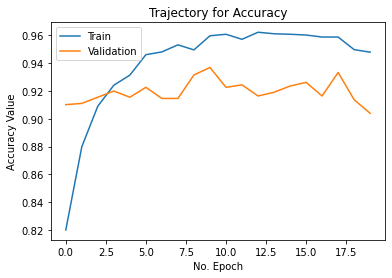

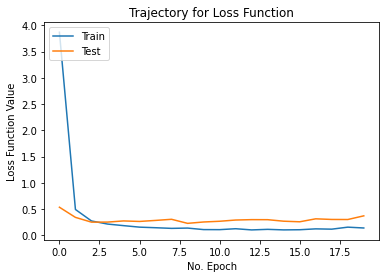

In [83]:
# Plot loss function
import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'
plot_accuracy(history)

In [84]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

8/8 [==============================] - 16s 2s/step - loss: 0.3598 - accuracy: 0.8984
Test accuracy : 0.8984375


In [85]:
model.save('model.1')

INFO:tensorflow:Assets written to: model.1\assets


## Extending the VGG19 Models

In [88]:
### Exntending the VGG19 Model
num_classes = 3
base_model = VGG19(weights='imagenet',
                   input_shape= (128,128,3),
                   classes = num_classes,
                   include_top = False)
#freeze the base_model
base_model.trainable = False

# extend the VGG
x = base_model.output
x = tf.keras.layers.Conv2D(512, (3,3),activation='relu')(x) 
x = tf.keras.layers.Conv2D(512, (2,2),activation='relu')(x) 
x = tf.keras.layers.Conv2D(512, (1,1),activation='relu')(x) 

#create a new model on top
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(base_model.inputs,outputs)
model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0  

In [89]:
model.compile(optimizer = 'adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 20
history = model.fit(train_ds, epochs = epochs, validation_data = validation_dataset)

Epoch 1/20
173/173 [==============================] - 398s 2s/step - loss: 0.8124 - accuracy: 0.8669 - val_loss: 0.2555 - val_accuracy: 0.9226
Epoch 2/20
173/173 [==============================] - 422s 2s/step - loss: 0.2063 - accuracy: 0.9346 - val_loss: 0.2015 - val_accuracy: 0.9431
Epoch 3/20
173/173 [==============================] - 390s 2s/step - loss: 0.1722 - accuracy: 0.9468 - val_loss: 0.2693 - val_accuracy: 0.9306
Epoch 4/20
173/173 [==============================] - 376s 2s/step - loss: 0.1479 - accuracy: 0.9536 - val_loss: 0.1873 - val_accuracy: 0.9457
Epoch 5/20
173/173 [==============================] - 398s 2s/step - loss: 0.1202 - accuracy: 0.9600 - val_loss: 0.3177 - val_accuracy: 0.9137
Epoch 6/20
173/173 [==============================] - 396s 2s/step - loss: 0.1023 - accuracy: 0.9654 - val_loss: 0.2137 - val_accuracy: 0.9351
Epoch 7/20
173/173 [==============================] - 400s 2s/step - loss: 0.0881 - accuracy: 0.9699 - val_loss: 0.2335 - val_accuracy: 0.9351

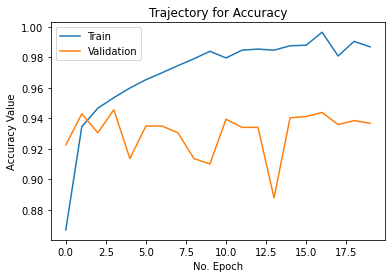

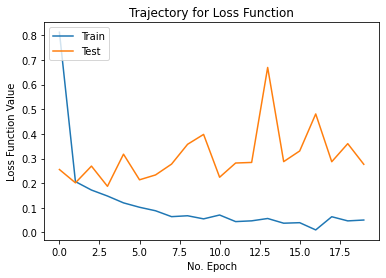

In [90]:
plot_accuracy(history)

In [91]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

8/8 [==============================] - 14s 2s/step - loss: 0.3925 - accuracy: 0.9453
Test accuracy : 0.9453125


In [92]:
model.save('model.2')

INFO:tensorflow:Assets written to: model.2\assets


## Extending VGG19 model with Data Augmentation

In [3]:
## adapted from https://www.tensorflow.org/tutorials/images/data_augmentation
from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [4]:
IMG_SIZE = 128

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

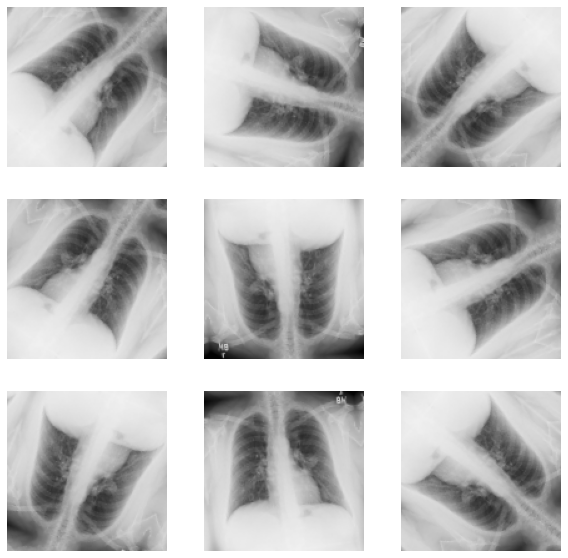

In [95]:
#data augmentation code
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    images = images[1]
    labels = labels[1]
    for i in range(9):
    #print(images[i])
    #print(labels[i])
        augmented_image = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image.numpy().astype('uint8'))
        #plt.title(class_names[labels])
        plt.axis("off")

In [96]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

In [97]:
model.compile(optimizer = 'adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 20
history = model.fit(aug_ds, epochs = epochs, validation_data = validation_dataset)

Epoch 1/20
173/173 [==============================] - 343s 2s/step - loss: 0.5079 - accuracy: 0.7957 - val_loss: 3.6631 - val_accuracy: 0.8915
Epoch 2/20
173/173 [==============================] - 340s 2s/step - loss: 0.2493 - accuracy: 0.9181 - val_loss: 5.3396 - val_accuracy: 0.8746
Epoch 3/20
173/173 [==============================] - 339s 2s/step - loss: 0.2083 - accuracy: 0.9299 - val_loss: 7.5929 - val_accuracy: 0.8719
Epoch 4/20
173/173 [==============================] - 330s 2s/step - loss: 0.1768 - accuracy: 0.9395 - val_loss: 11.0894 - val_accuracy: 0.8496
Epoch 5/20
173/173 [==============================] - 329s 2s/step - loss: 0.1520 - accuracy: 0.9529 - val_loss: 16.2982 - val_accuracy: 0.8221
Epoch 6/20
173/173 [==============================] - 329s 2s/step - loss: 0.1409 - accuracy: 0.9520 - val_loss: 32.9253 - val_accuracy: 0.7785
Epoch 7/20
173/173 [==============================] - 329s 2s/step - loss: 0.1410 - accuracy: 0.9536 - val_loss: 32.8521 - val_accuracy: 0.

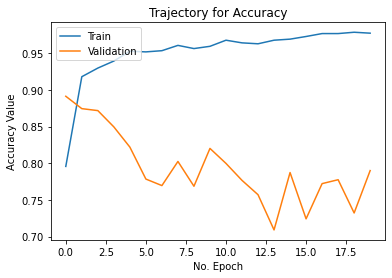

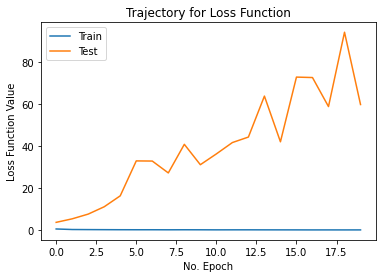

In [98]:
plot_accuracy(history)

In [99]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

8/8 [==============================] - 15s 2s/step - loss: 68.4337 - accuracy: 0.7891
Test accuracy : 0.7890625


In [100]:
model.save('model.3')

INFO:tensorflow:Assets written to: model.3\assets


## MultiClass Evaluation against Extended VGG19 Model

* Recall is the porpotion of the positive is corectly classified which is true positive over all positive (true positive + false negative) 
* Precision is the porpotion of predicted positives is truly positive which is true positive over the all predicted positive
* F1 is the weighted average of precision and recall, which is a combination metrics

In [134]:
# save and load models
# https://www.tensorflow.org/tutorials/keras/save_and_load
new_model = tf.keras.models.load_model('model.2')

# Check its architecture
#new_model.summary()

In [119]:
loss, accuracy = new_model.evaluate(test_dataset,batch_size =32)
print('Test accuracy :', accuracy)

8/8 [==============================] - 16s 2s/step - loss: 0.3621 - accuracy: 0.9531
Test accuracy : 0.953125


In [120]:
y_pred = []
for item in test_dataset:
    xi, yi = item
    predictions = new_model.predict_on_batch(xi)
    predictions1 = []
    for i in range(32):
    #print(i)
        max_value = max(predictions[i])
    #print(max_value)
        result = np.where(predictions[i] == max_value)
    #print(result[0][0])
        predictions1.append(result[0][0])
    y_pred += predictions1
    
#print(y_pred)

In [121]:
#print(y_pred)
#len(y_pred)

In [122]:
#Getting y_true
# adapted from https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset
y_true = []
for item in test_dataset:
    xi,yi = item
    label_batch = yi.numpy().tolist()
    y_true += label_batch

In [123]:
#print(y_true)
#len(y_true)

In [124]:
# Adapted from: https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print('Classification Report')
target_names = ['covid', 'normal', 'pneumonia']
print(classification_report(y_true, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       covid       0.34      0.37      0.36        81
      normal       0.27      0.30      0.29        76
   pneumonia       0.37      0.31      0.34        99

    accuracy                           0.33       256
   macro avg       0.33      0.33      0.33       256
weighted avg       0.33      0.33      0.33       256



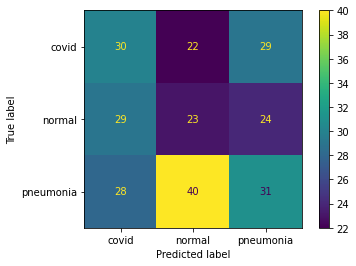

In [125]:
#get a matrxi plot to summarize performance by class
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred), display_labels=target_names)
disp.plot()

0.49639915240932114

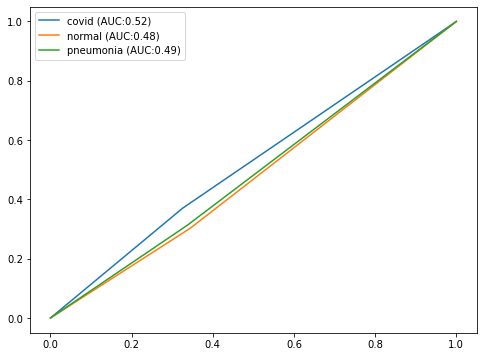

In [126]:
#mult-class roc auc score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

fig, c_ax = plt.subplots(1,1, figsize = (8, 6))

multiclass_roc_auc_score(y_true, y_pred)

# Evaluation of Data Augmented VGG19 (Extended)


In [86]:
# save and load models
# https://www.tensorflow.org/tutorials/keras/save_and_load
new_model = tf.keras.models.load_model('model.3')

# Check its architecture
#new_model.summary()

In [87]:
y_pred = []
for item in test_dataset:
    xi, yi = item
    predictions = new_model.predict_on_batch(xi)
    predictions1 = []
    for i in range(32):
    #print(i)
        max_value = max(predictions[i])
    #print(max_value)
        result = np.where(predictions[i] == max_value)
    #print(result[0][0])
        predictions1.append(result[0][0])
    y_pred += predictions1
    
#print(y_pred)

In [88]:
#Getting y_true
# adapted from https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset
y_true = []
for item in test_dataset:
    xi,yi = item
    label_batch = yi.numpy().tolist()
    y_true += label_batch

In [89]:
# Adapted from: https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print('Classification Report')
target_names = ['covid', 'normal', 'pneumonia']
print(classification_report(y_true, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       covid       0.40      0.24      0.30        91
      normal       0.40      0.62      0.48        81
   pneumonia       0.35      0.31      0.33        84

    accuracy                           0.38       256
   macro avg       0.38      0.39      0.37       256
weighted avg       0.38      0.38      0.37       256



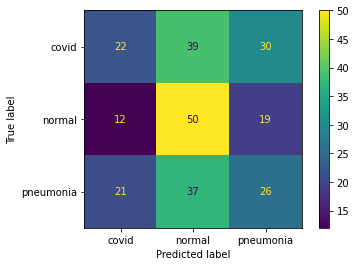

In [90]:
#get a matrxi plot to summarize performance by class
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred), display_labels=target_names)
disp.plot()

0.5415660944472314

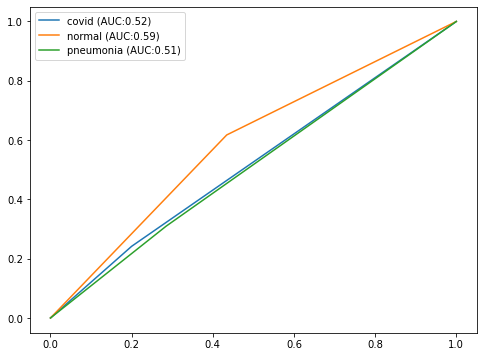

In [91]:
#mult-class roc auc score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

fig, c_ax = plt.subplots(1,1, figsize = (8, 6))

multiclass_roc_auc_score(y_true, y_pred)

# Evaluation against Plain VGG19 Model

In [128]:
# save and load models
# https://www.tensorflow.org/tutorials/keras/save_and_load
new_model = tf.keras.models.load_model('model.1')

# Check its architecture
#new_model.summary()

In [129]:
y_pred = []
for item in test_dataset:
    xi, yi = item
    predictions = new_model.predict_on_batch(xi)
    predictions1 = []
    for i in range(32):
    #print(i)
        max_value = max(predictions[i])
    #print(max_value)
        result = np.where(predictions[i] == max_value)
    #print(result[0][0])
        predictions1.append(result[0][0])
    y_pred += predictions1
    
#print(y_pred)

In [130]:
#Getting y_true
# adapted from https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset
y_true = []
for item in test_dataset:
    xi,yi = item
    label_batch = yi.numpy().tolist()
    y_true += label_batch

In [131]:
# Adapted from: https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print('Classification Report')
target_names = ['covid', 'normal', 'pneumonia']
print(classification_report(y_true, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       covid       0.30      0.31      0.31        83
      normal       0.29      0.31      0.30        77
   pneumonia       0.34      0.30      0.32        96

    accuracy                           0.31       256
   macro avg       0.31      0.31      0.31       256
weighted avg       0.31      0.31      0.31       256



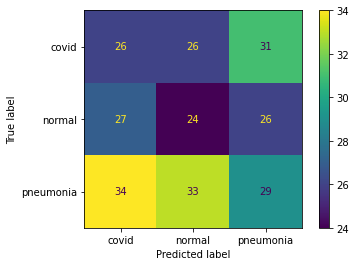

In [132]:
#get a matrxi plot to summarize performance by class
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred), display_labels=target_names)
disp.plot()

0.4814274270754979

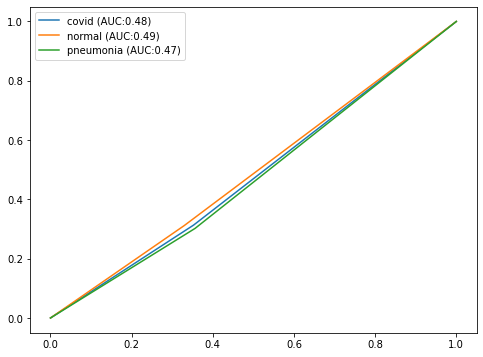

In [133]:
#mult-class roc auc score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

fig, c_ax = plt.subplots(1,1, figsize = (8, 6))

multiclass_roc_auc_score(y_true, y_pred)

### Issues / Improvements
1. Dataset is very small (128 x 128 px)
2. Need more hypertuning (epochs = 20) 
3. Lack of cross-validaiton

###  References
- Chaddad, A., Hassan, L., & Desrosiers, C. (2021). Deep CNN models for predicting COVID-19  in CT  and x- ray images. Journal of Medical Imaging, 8(S1), 014502.  ​

- https://www.kaggle.com/jefinpaul/covid-pneumonia-and-normal-using-resnet50-xray​

- https://www.kaggle.com/amanullahasraf/covid19-pneumonia-normal-chest-xray-pa-dataset​